In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Metric MSE

In [40]:
def mean_square_error(y_pred, y_real):
    if y_pred.shape[0] != y_real.shape[0]:
        raise ValueError("Predictions must have same length than target")

    n = y_real.shape[0]
    loss = 0
    for i in range(n):
        loss += (y_real[i] - y_pred[i])**2
    loss = loss / n 
    return loss[0]

## Creating the dataset artificially

In [2]:
np.random.seed(42)
m = 100
d = 1
X = np.random.rand(m ,d)
X_b = np.hstack(( np.ones((m, 1)), X))
y = 3 * X + 5 + np.random.rand(m ,d)

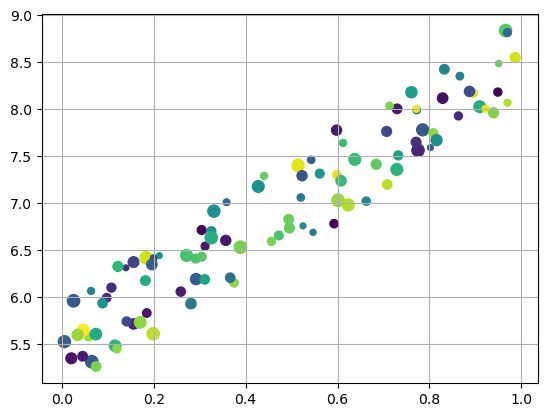

In [15]:
sizes = np.random.uniform(15, 80, len(X))
colors = np.random.uniform(15, 80, len(X))
fig, ax = plt.subplots()
ax.scatter(X, y, c=colors, s=sizes)
plt.grid()
plt.show()

# Linear regression normal equation

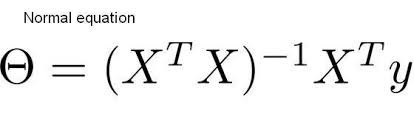

# Theta is the value that minimise de cost function

In [51]:
theta = np.linalg.inv(X_b.T @ X_b) @ X_b.T @ y

In [52]:
theta

array([[5.51359766],
       [2.96646836]])

In [53]:
y_pred = theta[1][0] * X + theta[0][0]

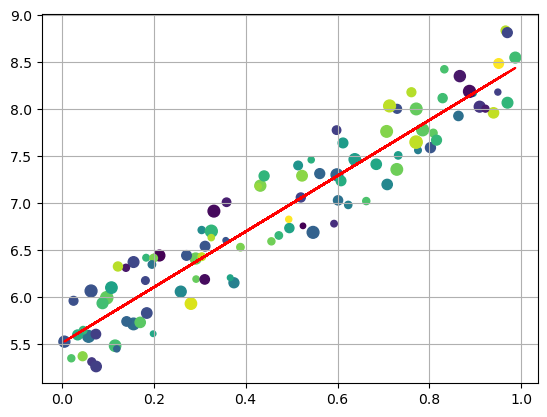

In [54]:
sizes = np.random.uniform(15, 80, len(X))
colors = np.random.uniform(15, 80, len(X))
fig, ax = plt.subplots()
ax.scatter(X, y, c=colors, s=sizes)
ax.plot(X, y_pred, c='red')
plt.grid()
plt.show()

In [55]:
print(f"Linear regression MSE with normal equation: {mean_square_error(y_pred, y)}")

Linear regression MSE with normal equation: 0.08495655256593737


# Linear regression with SVD

# Difference between inv and pinv:
## inv will return the inverse of the matrix if the det is different from 0
## pinv will return the psuedo inverse if the matrix is not inversible else it will return the inverse like inv

In [56]:
theta_svd = np.linalg.pinv(X_b) @ y

In [57]:
theta_svd

array([[5.51359766],
       [2.96646836]])

In [58]:
y_pred_svd = theta_svd[1][0] * X + theta_svd[0][0]

sizes = np.random.uniform(15, 80, len(X))
colors = np.random.uniform(15, 80, len(X))
fig, ax = plt.subplots()
ax.scatter(X, y, c=colors, s=sizes)
ax.plot(X, y_pred_svd, c='red')
plt.grid()
plt.show()

In [61]:
print(f"Linear regression MSE with SVD method: {mean_square_error(y_pred_svd, y)}")
print(f"Difference between Normal and SVD: {mean_square_error(y_pred, y) - mean_square_error(y_pred_svd, y)}")

Linear regression MSE with SVD method: 0.0849565525659374
Difference between Normal and SVD: -2.7755575615628914e-17


# Complexity algorithm
### Inversing a matrix is between O(n²,⁴) and O(n³), O(m)
### SVD approach is O(n²) and O(m)
### Where n represent the number of variables and m the number of samples

# Stochastic gradient descent approach

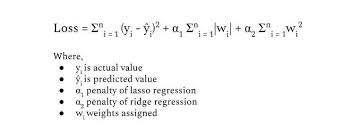

# Adding regularisation

In [313]:
class LinearRegression:
    def __init__(self, epochs=100, lr=0.01, batch_size=32, penalty="none", alpha=0.01, l1_ratio=0.5):
        if epochs < 0:
            raise ValueError("epoch must be positive")
            
        if lr < 0:
            raise ValueError("learning rate must be postive")
            
        if batch_size < 0:
            raise ValueError("Batch size must be positive")

        if penalty.lower() not in ("none", "l1", "l2", "elastic net"):
            raise ValueError("Penalty accepted are L1, L2 and Elastic net")
                                                           
        self.weight = None
        self.epochs = epochs
        self.lr = lr
        self.batch_size = batch_size
        self.alpha = alpha
        self.l1_ratio = l1_ratio
        self.penalty = penalty
        
    def fit(self, X, y):
        
        if X.shape[0] != y.shape[0]:
            raise ValueError(f'Features must have same dimension than as target: {X.shape[0]} != {y.shape[0]}')
            
        self.samples, self.features = X.shape
        self.weight = np.random.randn(self.features , 1).astype(np.float32)
        self.biais = np.zeros((1, 1), np.float32)
        y = np.array(y, dtype=np.float32)
       
        batches = (self.samples + self.batch_size -1) // self.batch_size
        
        for epoch in range(self.epochs):
            #Shuffle data for better generalisation
            indices = np.random.permutation(self.samples)
            X, y = X[indices], y[indices]
            
            total_loss = 0
            for batch in range(batches):
                start = batch * self.batch_size
                end = min((batch + 1) * self.batch_size, self.samples)
                
                X_batch, y_batch = X[start:end], y[start:end]
        
                y_pred = self.prediction(X_batch)
    
                loss = self.mean_square_error(y_pred, y_batch)

                #Gradient descent
                dw = np.dot(X_batch.T, (y_pred - y_batch))
                db = np.sum(y_pred - y_batch)

                #Adding regularisation
                if self.penalty == "l2":
                    dw += self.alpha * self.weight
                elif self.penalty == "l1":
                    dw += self.alpha * np.sign(self.weight)
                elif self.penalty == "elastic net":
                    dw += self.alpha * (self.l1_ratio * np.sign(self.weight) + (1 - self.l1_ratio) * self.weight)

                self.weight -= self.lr * dw
                self.biais -= self.lr * db
    
                total_loss += loss
            print(f"epoch: {epoch+1}, training loss: {total_loss/batches:.4f}")
        
            
    def mean_square_error(self, y_pred, y_true):
        
        if y_pred.shape[0] != y_true.shape[0]:
            raise ValueError("Predictions and targets must have the same dimension")
            
        n = y_true.shape[0]
        y_true = y_true.flatten()
        y_pred = y_pred.flatten()
        total_loss = 0
        omega = 0
        
        for i in range(n):
            omega = y_true[i] - y_pred[i]
            total_loss += omega**2
            
        return total_loss/n
        
    def prediction(self, X):
        if self.weight is None:
            raise ValueError("Model must be trained before calling prediction")
        
        return np.dot(X, self.weight) + self.biais
    

In [314]:
lr = LinearRegression(penalty='l2', alpha=0.1)
lr.fit(X, y)
y_pred_lr = lr.prediction(X)

epoch: 1, training loss: 21.9388
epoch: 2, training loss: 1.1079
epoch: 3, training loss: 0.1869
epoch: 4, training loss: 0.1304
epoch: 5, training loss: 0.1230
epoch: 6, training loss: 0.1220
epoch: 7, training loss: 0.1275
epoch: 8, training loss: 0.1332
epoch: 9, training loss: 0.1002
epoch: 10, training loss: 0.0986
epoch: 11, training loss: 0.1485
epoch: 12, training loss: 0.1006
epoch: 13, training loss: 0.1067
epoch: 14, training loss: 0.1211
epoch: 15, training loss: 0.1051
epoch: 16, training loss: 0.0905
epoch: 17, training loss: 0.0868
epoch: 18, training loss: 0.1018
epoch: 19, training loss: 0.1255
epoch: 20, training loss: 0.0853
epoch: 21, training loss: 0.0927
epoch: 22, training loss: 0.0855
epoch: 23, training loss: 0.0840
epoch: 24, training loss: 0.0923
epoch: 25, training loss: 0.1031
epoch: 26, training loss: 0.0784
epoch: 27, training loss: 0.0910
epoch: 28, training loss: 0.1099
epoch: 29, training loss: 0.0954
epoch: 30, training loss: 0.0824
epoch: 31, trainin

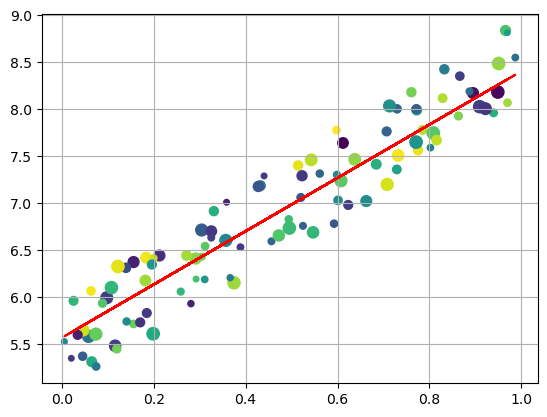

In [315]:
sizes = np.random.uniform(15, 80, len(X))
colors = np.random.uniform(15, 80, len(X))
fig, ax = plt.subplots()
ax.scatter(X, y, c=colors, s=sizes)
ax.plot(X, y_pred_lr, c='red')
plt.grid()
plt.show()

In [316]:
print(f"The mean square error of SGD approach: {mean_square_error(y_pred_lr, y)}")

The mean square error of SGD approach: 0.0864852135720955
